In [49]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Perfect zc bond is difficult to find
### Build a portfolio of regular coupon payong bonds that matches the liability when int rate changes

In [5]:
erk.bond_cash_flows(3,100,0.03,2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [7]:
erk.bond_price(20,1000,0.05,2,0.04)

1136.7773962036904

In [9]:
erk.bond_price(20,1000,0.05,2,0.05)

1000.0000000000023

In [10]:
erk.bond_price(20,1000,0.05,2,0.02)

1492.520291709342

In [11]:
# int rate falls, bond price rises

In [13]:
rates=np.linspace(0.01,0.1,num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [14]:
prices=[erk.bond_price(10,1000,0.05,2,rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

<AxesSubplot:title={'center':'price of 10-yr-bond of different int rate'}>

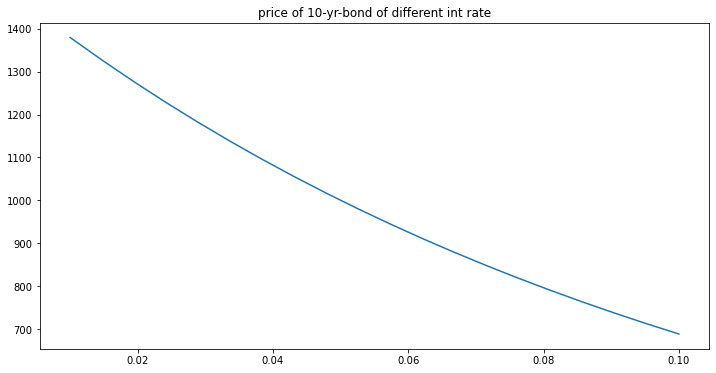

In [15]:
pd.DataFrame(data=prices,index=rates).plot(title='price of 10-yr-bond of different int rate',legend=False,figsize=(12,6))

#### use this 10-yr bond as a hedge is not a good idea
#### we need to contruct a portfolio of bonds that has resilience to int rate as zc bond does
#### zc bond has resilience because it only has one payment, so int rate in the middle doesn't matter

In [19]:
cf=erk.bond_cash_flows(3,1000,0.06,2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [21]:
# compute the effective waiting period of getting my money back
# weight as the pv of the cf

In [22]:
discounts=erk.discount(cf.index,0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [23]:
dcf=discounts*cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [25]:
weights=dcf/dcf.sum()
weights
# get weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

### weight average duration = macaulary duration

In [28]:
# directly link to the amount of the price will change when int rate change
# apply weights to each period and sum them
# weight by the pv of each cf
(cf.index*weights).sum()

5.579707187194534

In [29]:
# for zc bond, the mac duration is exactly the maturity
# for regular bond, the mac duration will be shorter than maturities

In [31]:
erk.macaulay_duration(erk.bond_cash_flows(3,1000,0.06,2),0.06/2)

5.579707187194534

In [32]:
### Rational: if we can match the mac duration of the bonds to the mac duration of liability
### we get 2 portfolios that have the same sensitivity to the change in int rate

## Duration Matching

In [34]:
liabilities=pd.Series(data=[100000,100000],index=[10,12])    # index indicates time due
erk.macaulay_duration(liabilities,0.04)

10.960799385088393

In [35]:
## get a mac duration somewhere between 10 and 12

In [37]:
## idealy, we want a zc bond that has a duration of 10.96079
# or we can buy individual zc bonds with 10 and 12 maturities

In [38]:
## but we only have 10 and 20 year maturity bonds

In [39]:
md_10=erk.macaulay_duration(erk.bond_cash_flows(10,1000,0.05,1),0.04)  # 10 year bond
md_20=erk.macaulay_duration(erk.bond_cash_flows(20,1000,0.05,1),0.04)  # 20 year bond

In [40]:
md_10,md_20

(8.190898824083233, 13.544718122145921)

In [41]:
## the reason why 20 year mac duration is much shorter is because the pv of last principle payment is much smaller

In [46]:
short_bond=erk.bond_cash_flows(10,1000,0.05,1)
long_bond=erk.bond_cash_flows(20,1000,0.05,1)
w_s=erk.match_durations(liabilities,short_bond,long_bond,0.04)
w_s

0.48263092069478974

In [47]:
# put 48% in short bond, 52% in long bond

In [60]:
p_short=erk.bond_price(10,1000,0.05,1,0.04)
p_long=erk.bond_price(20,1000,0.05,1,0.04)
a_0=130000
p_flows=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows,0.04)

10.960799385088393

In [61]:
# look at funding ratio now

In [62]:
cfr=erk.funding_ratio(p_flows,liabilities,0.04)
cfr

0.9998760012192478

<AxesSubplot:title={'center':'Funding ratio with changes in int rates'}>

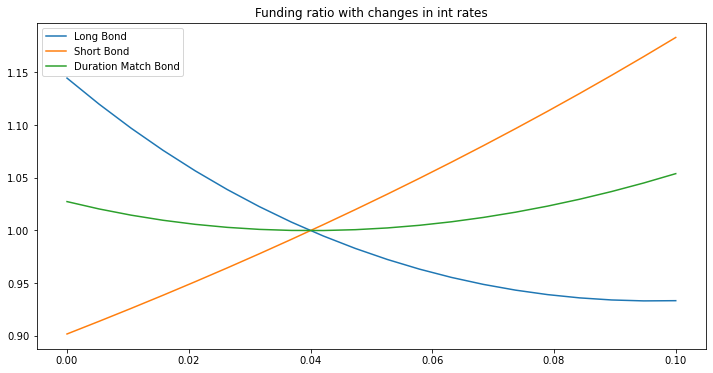

In [67]:
rates=np.linspace(0,0.1,20)
lb_assets=a_0*long_bond/p_long # if put 100% in long
sb_assets=a_0*short_bond/p_short # if put 100% in short

fr_change=pd.DataFrame({
    'Long Bond':[erk.funding_ratio(lb_assets,liabilities,r) for r in rates],
    'Short Bond':[erk.funding_ratio(sb_assets,liabilities,r) for r in rates],
    'Duration Match Bond':[erk.funding_ratio(p_flows,liabilities,r) for r in rates],
},index=rates)
fr_change.plot(title='Funding ratio with changes in int rates',figsize=(12,6))

In [ ]:
# if we all in long bond, if int rate goes down, ratio goes up, if int rate goes up, ratio worsens
# duration match portfolio has almost no change